In [6]:
import numpy as np
import os
import glob
import pandas as pd
import spikeinterface.extractors as se
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.ndimage import gaussian_filter

import warnings
from astropy.stats import circmean
%matplotlib inline
from astropy.convolution import convolve, convolve_fft
from skimage.morphology import disk
import random


def calculate_firing_rate_by_headdir(headdir, spikes, sync, num_bins=24):
    # Bin the head direction data
    headdir_bins = np.linspace(-180, 180, num_bins + 1)
    headdir_bin_centers = (headdir_bins[:-1] + headdir_bins[1:]) / 2

    # Calculate the occupancy in each bin
    occupancy, _ = np.histogram(headdir, bins=headdir_bins)

    # Calculate the number of spikes in each bin
    spike_headdir = np.interp(spikes, sync, headdir)
    spike_counts, _ = np.histogram(spike_headdir, bins=headdir_bins)

    # Calculate the firing rate in each bin (spikes per bin / occupancy per bin) adjust for 35Hz sampling
    firing_rate = np.divide(spike_counts, occupancy, where=occupancy != 0)*30
    firing_rate[occupancy == 0] = np.nan  # Avoid division by zero

    return headdir_bin_centers, firing_rate, occupancy


def plot_circular_firing_rate(headdir_bin_centers, firing_rate, neuronname=None, ax=None, savepath=None):
    """
    Plots firing rate as a function of head direction in a polar plot.
    If ax is provided, plot on it. Otherwise, create a new figure/axis.
    Optionally save to savepath.
    """
    # Convert head direction to radians
    headdir_bin_centers_rad = np.deg2rad(headdir_bin_centers)
    width = 2 * np.pi / len(headdir_bin_centers_rad)  # width of each bar (in radians)

    created_fig = False
    if ax is None:
        fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(6, 6))
        created_fig = True

    bars = ax.bar(headdir_bin_centers_rad, firing_rate, width=width, bottom=0.0, alpha=0.8)
    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)
    if neuronname:
        ax.set_title(f'Firing Rate by Head Direction\n{neuronname}')
    # You can add more styling or colorbars here if needed

    plt.tight_layout()

    if savepath is not None:
        if created_fig:
            plt.savefig(savepath, dpi=300)
        else:
            ax.figure.savefig(savepath, dpi=300)

    # Only show if we created the figure in here (avoids showing it when used as a subplot)
    if created_fig:
        plt.show()
        return fig, ax
    else:
        return ax


def resultant_vector_length(alpha, w=None, d=None, axis=None,
                            axial_correction=1, ci=None, bootstrap_iter=None):
    """
    Copied from Pycircstat documentation
    Computes mean resultant vector length for circular data.

    This statistic is sometimes also called vector strength.

    :param alpha: sample of angles in radians
    :param w: number of incidences in case of binned angle data
    :param ci: ci-confidence limits are computed via bootstrapping,
               default None.
    :param d: spacing of bin centers for binned data, if supplied
              correction factor is used to correct for bias in
              estimation of r, in radians (!)
    :param axis: compute along this dimension, default is None
                 (across all dimensions)
    :param axial_correction: axial correction (2,3,4,...), default is 1
    :param bootstrap_iter: number of bootstrap iterations
                          (number of samples if None)
    :return: mean resultant length

    References: [Fisher1995]_, [Jammalamadaka2001]_, [Zar2009]_
    """
    if axis is None:
        axis = 0
        alpha = alpha.ravel()
        if w is not None:
            w = w.ravel()

    cmean = _complex_mean(alpha, w=w, axis=axis,
                          axial_correction=axial_correction)

    # obtain length
    r = np.abs(cmean)

    # for data with known spacing, apply correction factor to correct for bias
    # in the estimation of r (see Zar, p. 601, equ. 26.16)
    if d is not None:
        if axial_correction > 1:
            warnings.warn("Axial correction ignored for bias correction.")
        r *= d / 2 / np.sin(d / 2)
    return r


def _complex_mean(alpha, w=None, axis=None, axial_correction=1):
    # Copied from picircstat documentation
    if w is None:
        w = np.ones_like(alpha)
    alpha = np.asarray(alpha)

    assert w.shape == alpha.shape, "Dimensions of data " + str(alpha.shape) \
                                   + " and w " + \
        str(w.shape) + " do not match!"

    return ((w * np.exp(1j * alpha * axial_correction)).sum(axis=axis) /
            np.sum(w, axis=axis))

def get_sig_cells(spike_train_this_epoch, hd, epoch_start_frame, epoch_end_frame, occupancy_time,  frame_rate = 30, n_bins = 72):
    num_shifts = 1000
    shift_min = 0
    shift_max = epoch_end_frame - epoch_start_frame
    if shift_min > shift_max:
        shift_max_temp = shift_min
        shift_min = shift_max
        shift_max = shift_max_temp
        if shift_min < 0:
            shift_min = 0
    MRL_values = []


    current_data = spike_train_this_epoch


    if np.nanmin(hd) < -np.pi or np.nanmax(hd) > np.pi:
        hd_rad = np.deg2rad(hd)
    else:
        hd_rad = hd


    for shift_idx in range(num_shifts):
        # Get random shift value
        random_shift = random.randint(shift_min, shift_max)
        # Add or subtract the random_shift value from each element in the variable
        shifted_data = current_data + random_shift
        range_min = epoch_start_frame
        range_max = epoch_end_frame
        range_size = range_max - range_min + 1
        
        # Ensure shifted_data stays within the range [range_min, range_max]
        shifted_data = np.mod(shifted_data - range_min, range_size) + range_min
        # Calculate angles_degrees and MRL
        angles_radians= hd_rad[shifted_data]; 
        mask = ~np.isnan(angles_radians)
        angles_radians= angles_radians[mask]

        counts, bin_edges = np.histogram(angles_radians, bins=n_bins,range = [-np.pi, np.pi] )
        bin_idx = np.digitize(angles_radians, bin_edges) - 1  # zero-based index for Python
        
        direction_firing_rate = np.divide(counts, occupancy_time, out=np.full_like(counts, np.nan, dtype=float), where=occupancy_time!=0)

        bin_idx = np.clip(bin_idx, 0, len(direction_firing_rate) - 1)
        W = direction_firing_rate[bin_idx]

        MRL = resultant_vector_length(angles_radians, w=W)
        MRL_values.append( MRL)

    perc_95_val = np.percentile(MRL_values, 95)
    perc_99_val = np.percentile(MRL_values, 99)
    return perc_95_val, perc_99_val, MRL_values


def get_sig_cells_m2(spike_train_this_epoch, hd,epoch_start_frame, epoch_end_frame,  occupancy_time, frame_rate = 30, n_bins = 72):
    num_shifts = 1000
    shift_min = 0
    shift_max = epoch_end_frame - epoch_start_frame
    if shift_min > shift_max:
        shift_max_temp = shift_min
        shift_min = shift_max
        shift_max = shift_max_temp
        if shift_min < 0:
            shift_min = 0
    MRL_values = []


    current_data = spike_train_this_epoch
    current_angles = hd

    if np.nanmin(hd) < -np.pi or np.nanmax(hd) > np.pi:
        hd_rad = np.deg2rad(hd)
    else:
        hd_rad = hd

    for shift_idx in range(num_shifts):
        # Get random shift value
        random_shift = random.randint(shift_min, shift_max)

        # Add or subtract the random_shift value from each element in the variable
        shifted_data = current_data + random_shift

        range_min = epoch_start_frame
        range_max = epoch_end_frame
        range_size = range_max - range_min + 1
        
        # Ensure shifted_data stays within the range [range_min, range_max]
        shifted_data = np.mod(shifted_data - range_min, range_size) + range_min

        # Calculate angles_degrees and MRL
        angles_radians= hd_rad[shifted_data]; 
        mask = ~np.isnan(angles_radians)
        angles_radians= angles_radians[mask]

        counts, bin_edges = np.histogram(angles_radians, bins=n_bins,range = [-np.pi, np.pi] )

        direction_firing_rate = np.divide(counts, occupancy_time, out=np.full_like(counts, np.nan, dtype=float), where=occupancy_time!=0)
        direction_firing_rate[np.isnan(direction_firing_rate)] = 0
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

        MRL = resultant_vector_length(bin_centers, w = direction_firing_rate)

        MRL_values.append( MRL)

    perc_95_val = np.percentile(MRL_values, 95)
    perc_99_val = np.percentile(MRL_values, 99)
    return perc_95_val, perc_99_val, MRL_values

def resultant_vector_length_m2(angles, w=None):
    """
    angles: array of angles in radians
    w: optional weights
    """
    if w is None:
        w = np.ones_like(angles)
    x = np.sum(w * np.cos(angles))
    y = np.sum(w * np.sin(angles))
    R = np.sqrt(x**2 + y**2)
    return R / np.sum(w)


In [7]:
hd = np.array([0,180 ,0,180,180])
hd_epoch1 = np.array([0,180])
hd_epoch2 = np.array([0,180,180])
spike_train = np.array([0,1,1, 2, 3, 4])

start_times = [0,2]
end_times = [1,4]

In [8]:
hd = np.array([0,180 ,0,180,180, 0, 0, 0,0])
hd_epoch1 = np.array([0,180])
hd_epoch2 = np.array([0,180,180, 0])
spike_train = np.array([0,1,1,4, 5, 6])

start_times = [0,2]
end_times = [1,8]

[  0 180]
[  0 180 180]
mu1: 180.0
m2: 178.50030450148256
e 0: MRL 0.60, MRL_method2 0.33, 95th m1 0.6000000000000001, 95th m2 0.33343485443593773


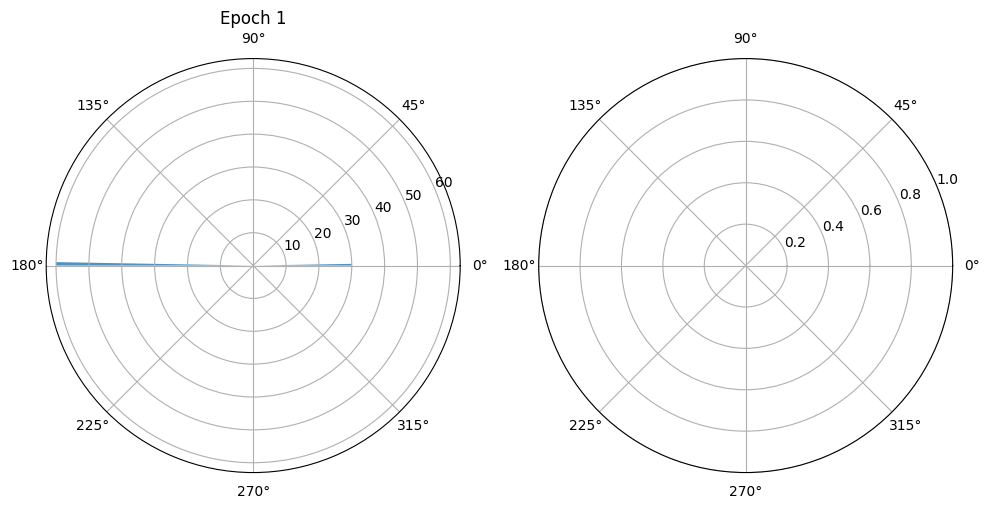

In [13]:

directional_data_all_units = pd.DataFrame(
columns=[
    'cell', 'trial', 'epoch', 'MRL', 'mean_direction',
    'percentiles95', 'percentiles99', 'significant','MRL_method2', 'percentiles95_m2', 'percentiles99_m2', 'significant_m2', 'num_spikes'
]
)

# Creating figure
fig, axs = plt.subplots(1, 2, figsize = [10, 5],  subplot_kw = {'projection': 'polar'})
axs = axs.flatten()
counter = 0 # counts which axs we're on
frame_rate = 30

for e in range(1):
    spike_train_this_epoch = np.array([el for el in spike_train if el >= start_times[e] and el <= end_times[e]])
    # HD calculations
    if len(spike_train_this_epoch) > 0:
        num_bins = 360
        hd_this_epoch = hd[start_times[e]:end_times[e] + 1]
        print(hd_this_epoch)
        hd_this_epoch = hd_this_epoch[~np.isnan(hd_this_epoch)]
        hd_this_epoch_rad = np.deg2rad(hd_this_epoch)
        occupancy_counts, _ = np.histogram(hd_this_epoch_rad, bins=num_bins, range = [-np.pi, np.pi])
        occupancy_time = occupancy_counts / frame_rate 

        spikes_hd = hd[spike_train_this_epoch]
        print(spikes_hd)
        spikes_hd = spikes_hd[~np.isnan(spikes_hd)]
        spikes_hd_rad = np.deg2rad(spikes_hd)
        counts, bin_edges = np.histogram(spikes_hd_rad, bins=num_bins,range = [-np.pi, np.pi] )
        bin_idx = np.digitize(spikes_hd_rad, bin_edges) - 1  # zero-based index for Python

        direction_firing_rate = np.divide(counts, occupancy_time, out=np.full_like(counts, np.nan, dtype=float), where=occupancy_time!=0)
        direction_firing_rate = np.array([0 if np.isnan(el) else el for el in direction_firing_rate])
        bin_idx = np.clip(bin_idx, 0, len(direction_firing_rate) - 1)

        W = direction_firing_rate[bin_idx]

        # 6. Circular statistics
        MRL = resultant_vector_length(spikes_hd_rad, w=W)
        mu = circmean(spikes_hd_rad, weights=W)
        mean_angle_deg = np.rad2deg(mu)
        print(f"mu1: {mean_angle_deg}")

        if np.isnan(MRL):
            raise ValueError(f"MRL is NAN, num_spikes = {len(spike_train_this_epoch)}")

        # Getting significance

        percentiles_95_value, percentiles_99_value, MRL_values = get_sig_cells(spike_train_this_epoch, hd, start_times[e], end_times[e], occupancy_time, n_bins= num_bins)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        MRL_method2 = resultant_vector_length(bin_centers, w = direction_firing_rate)
        percentiles_95_value_m2, percentiles_99_value_m2, MRL_values_m2 = get_sig_cells_m2(spike_train_this_epoch, hd, start_times[e], end_times[e], occupancy_time, n_bins = num_bins)
        mu2 = circmean(bin_centers, weights = direction_firing_rate)
        print(f"m2: {np.rad2deg(mu2)}")
        # Add significance data for every element (even if not significant)
        new_element = {
            'cell': None,
            'trial': None,
            'epoch': e,
            'MRL': MRL,
            'MRL_method2': MRL_method2,
            'mean_direction': mu,
            'percentiles95': percentiles_95_value,
            'percentiles99': percentiles_99_value,
            'significant': 'ns', 
            'percentiles95_m2': percentiles_95_value_m2, 
            'percentiles99_m2': percentiles_99_value_m2,
            'significant_m2': 'ns',
            'num_spikes': len(spike_train_this_epoch)
        }

        if MRL > percentiles_95_value:
            new_element['significant'] = 'sig'

        if MRL_method2 > percentiles_95_value_m2:
            new_element['significant_m2'] = 'sig'
        
        print(f"e {e}: MRL {MRL:.2f}, MRL_method2 {MRL_method2:.2f}, 95th m1 {percentiles_95_value}, 95th m2 {percentiles_95_value_m2}")

        directional_data_all_units.loc[len(directional_data_all_units)] = new_element

    # Plot
    
    width = np.diff(bin_centers)[0]

    if len(spike_train_this_epoch) > 0:
        bars = axs[counter].bar(
            bin_centers,
            direction_firing_rate,
            width=width,
            bottom=0.0,
            alpha=0.8
        )

        axs[counter].text(
            np.pi/3,                # angle in radians
            np.nanmax(direction_firing_rate)*1.25,         # radius (just outside the bar)
            f"MRL = {MRL:.2f}",   # label text
            ha='center',
            va='bottom',
            fontsize=8,
            rotation_mode='anchor',
            color = 'w',
        )


        
    axs[counter].set_title(f"Epoch {e + 1}")

    counter += 1 

        
plt.tight_layout()
plt.show()


In [19]:
indx = [i for i in range(len(direction_firing_rate)) if direction_firing_rate[i] > 0]
arr = bin_centers[indx]
arr = np.rad2deg(arr)
print(arr)

[  0.5 179.5]


In [23]:
direction_firing_rate[indx]

array([30., 60.])

In [24]:
np.rad2deg(circmean(np.array([0.5, 179.5]), weights = np.array([30, 60])))

-159.4428530262725

In [26]:
np.rad2deg(circmean(bin_centers, weights = direction_firing_rate))

178.50030450148256

In [27]:
np.rad2deg(-1.5707963267949)

-90.0000000000002

(array([268.,   0.,   0.,   0.,   0.,   0.,   0., 289.,   0., 443.]),
 array([0.23076923, 0.30769231, 0.38461538, 0.46153846, 0.53846154,
        0.61538462, 0.69230769, 0.76923077, 0.84615385, 0.92307692,
        1.        ]),
 <BarContainer object of 10 artists>)

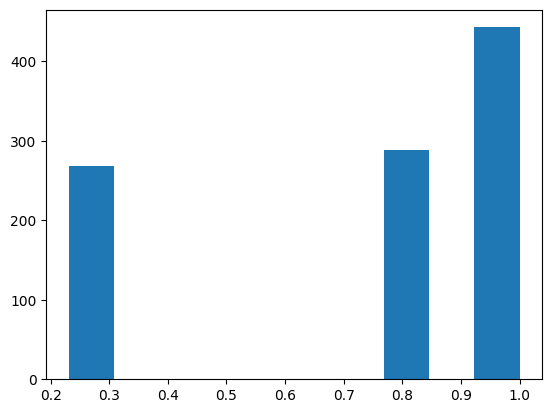

In [ ]:
plt.hist(MRL_values)

In [ ]:
mu = circmean(bin_centers, weights = direction_firing_rate)
np.rad2deg(mu)

177.751141268211

In [ ]:
direction_firing_rate = np.array(direction_firing_rate)

In [ ]:
arr = np.array([i for i in range(len(direction_firing_rate)) if direction_firing_rate[i] > 0])
print(arr)

[180 359]


In [ ]:
MRL_method2

0.004363309284746471